In [2]:
from sklearn.preprocessing import*
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv("aug_train.csv")

In [3]:
df.head(8)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0


In [4]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [8]:
from imblearn.over_sampling import SMOTENC
import pandas as pd

class Preprocessing:
    def __init__(self, df):
        self.df = df
        self.imputed_df = None
        self.balance_df = None
        self.featureEncoded_df = None
        self.target_mean_feature = []
        self.categorical_features_indices = []




    def handle_nulls(self):
      """Fill null values in specific columns."""
      self.df["enrolled_university"] = self.df["enrolled_university"].fillna("none")
      self.df["education_level"] = self.df["education_level"].fillna("Other")

      # Fill nulls in 'experience' with mode and ensure it's treated as numeric
      mode = self.df["experience"].mode()[0]
      self.df["experience"] = self.df["experience"].fillna(mode)  # Ensure it's float

      self.df["last_new_job"] = self.df["last_new_job"].fillna("Not Specified")
      self.df['major_discipline'] = self.df['major_discipline'].fillna("Not_Specified")
      self.df["gender"] = self.df["gender"].fillna("Not_specified")
      self.df["company_size"] = self.df["company_size"].fillna("NS")
      self.df["company_type"] = self.df["company_type"].fillna("not_specified")
      self.imputed_df = self.df
      return self.df

    def encode_features(self):
        # Encode categorical features with target mean.
        features = ['gender', "enrolled_university", "major_discipline",
                    "education_level", "company_type", "city"]

        for i, feature in enumerate(features):
            self.target_mean_feature.append(self.df.groupby(feature)['target'].mean())
            self.df[feature] = self.df[feature].map(self.target_mean_feature[i])

        rel_exp={'Has relevent experience':1,'No relevent experience':0}
        # Map relevant experience to binary values.
        self.df["relevent_experience"] = self.df["relevent_experience"].map(rel_exp)

        # Map company size categories to numerical values using map().
        size_mapping = {'NS':1,'<10': 2,'10/49': 3,'50-99': 4,'100-500': 5,'500-999': 6,'1000-4999': 7,'5000-9999': 8,'10000+': 9}
        self.df["company_size"]=self.df["company_size"].map(size_mapping)


        # Map last new job categories to numerical values.

        u=self.df["last_new_job"].unique().tolist()
        u.sort()
        un=[2,3,4,5,6,0,1]

        for i,j in zip(u,un):
          self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)


        # Map experience categories to numerical values.

        experience_mapping = {'<1': 0,'1': 1,'2': 2,'3': 3,'4': 4,\
                              '5': 5,'6': 6,'7': 7,'8': 8,'9': 9,\
                              '10': 10,'11': 11,'12': 12,'13': 13,\
                              '14': 14,'15': 15,'16': 16,'17': 17,\
                              '18': 18,'19': 19,'20': 20,'>20': 21,}
        for i,j in zip(experience_mapping.keys(),experience_mapping.values()):
          self.df["experience"]=self.df["experience"].replace(i,j)

        self.featureEncoded_df = self.df
        return self.df

    def balance_data(self):
        """Balance the dataset using SMOTENC."""
        X = self.df.drop("target", axis=1)
        y = self.df["target"]

        categorical_features_indices = [self.df.columns.get_loc(col) for col in['city', 'gender','relevent_experience',\
                                                                                'enrolled_university','education_level',\
                                                                                'major_discipline', 'experience',\
                                                                                'company_size', 'company_type',\
                                                                                'last_new_job']]

        smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)

        X_resampled, y_resampled = smote_nc.fit_resample(X, y)

        # Concatenate the resampled data back into a DataFrame
        self.balance_df = pd.concat([X_resampled, y_resampled], axis=1)

        # Store the balanced DataFrame back into self.df
        self.df = self.balance_df
        return self.balance_df

    def preprocess(self):
        """Run all preprocessing steps."""
        self.inputed_df = self.handle_nulls()
        self.balance_df = self.balance_data()
        self.featureEncoded_df = self.encode_features()
        return self.df


# Example usage:
# df = pd.read_csv('your_data.csv')
# preprocessor = Preprocessing(df)
# preprocessor.preprocess()
# processed_df = preprocessor.df

In [7]:
from preprocessing import Preprocessing
pre_pross = Preprocessing(df)

In [8]:
df = pre_pross.preprocess()

/workspaces/employeeRetentionPredection/preprocessing.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)
/workspaces/employeeRetentionPredection/preprocessing.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["experience"]=self.df["experience"].replace(i,j)


In [9]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2,36,1.0
1,29725,0.309524,0.776000,0.511016,0,0.477886,0.586342,0.548767,15,4,0.410194,6,47,0.0
2,11561,0.857658,0.624000,0.509899,0,0.628494,0.586342,0.548767,5,1,0.681263,1,83,0.0
3,33241,0.500000,0.789000,0.509899,0,0.334177,0.586342,0.276276,0,1,0.410194,1,52,1.0
4,666,0.434783,0.767000,0.511016,1,0.477886,0.326386,0.548767,21,4,0.163265,5,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,21952,0.857658,0.652873,0.511016,1,0.477886,0.586342,0.548767,8,5,0.410194,4,17,1.0
28758,2198,0.857658,0.764499,0.511016,1,0.477886,0.586342,0.548767,14,4,0.410194,6,68,1.0
28759,28092,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2,101,1.0
28760,5555,0.857658,0.699495,0.509899,1,0.477886,0.326386,0.548767,6,1,0.410194,2,147,1.0


In [10]:
df["target"].value_counts()

target
1.0    14381
0.0    14381
Name: count, dtype: int64

In [11]:
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [12]:
pre_pross.target_mean_feature[0]

gender
Female           0.313770
Male             0.511016
Not_specified    0.509899
Other            0.261780
Name: target, dtype: float64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28762 entries, 0 to 28761
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             28762 non-null  int64  
 1   city                    28762 non-null  float64
 2   city_development_index  28762 non-null  float64
 3   gender                  28762 non-null  float64
 4   relevent_experience     28762 non-null  int64  
 5   enrolled_university     28762 non-null  float64
 6   education_level         28762 non-null  float64
 7   major_discipline        28762 non-null  float64
 8   experience              28762 non-null  int64  
 9   company_size            28762 non-null  int64  
 10  company_type            28762 non-null  float64
 11  last_new_job            28762 non-null  int64  
 12  training_hours          28762 non-null  int64  
 13  target                  28762 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 

In [14]:
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [17]:
X = df.drop("target",axis=1)
y = df["target"]


In [18]:
y.value_counts()

target
1.0    14381
0.0    14381
Name: count, dtype: int64

In [ ]:
X

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2,36
1,29725,0.309524,0.776000,0.511016,0,0.477886,0.586342,0.548767,15,4,0.410194,6,47
2,11561,0.857658,0.624000,0.509899,0,0.628494,0.586342,0.548767,5,1,0.681263,1,83
3,33241,0.500000,0.789000,0.509899,0,0.334177,0.586342,0.276276,0,1,0.410194,1,52
4,666,0.434783,0.767000,0.511016,1,0.477886,0.326386,0.548767,21,4,0.163265,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,21952,0.857658,0.652873,0.511016,1,0.477886,0.586342,0.548767,8,5,0.410194,4,17
28758,2198,0.857658,0.764499,0.511016,1,0.477886,0.586342,0.548767,14,4,0.410194,6,68
28759,28092,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2,101
28760,5555,0.857658,0.699495,0.509899,1,0.477886,0.326386,0.548767,6,1,0.410194,2,147


In [20]:
scaler = StandardScaler()
X =scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
"""

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score

models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier":RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #training metrics
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred)
    model_train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    #test metrics

    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred)
    model_test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred)

    # Prepare the model name
    x = (list(models.keys())[i])

    # Create the output string using f-strings for formatting
    output = f
    --------------------------------------------------------------------

    {x.upper()}

    --------------------------------------------------------------------
    ********************************************************************

    Accuracy:
    - Accuracy_train: {model_train_accuracy:.4f}
    - Accuracy_test: {model_test_accuracy:.4f}

    --------------------------------------------------------------------

    Precision:
    - Precision_train: {model_train_precision:.4f}
    - Precision_test: {model_test_precision:.4f}

    --------------------------------------------------------------------

    Recall:
    - Recall_train: {model_train_recall:.4f}
    - Recall_test: {model_test_recall:.4f}

    --------------------------------------------------------------------

    F1 Score:
    - F1 Score_train: {model_train_f1:.4f}
    - F1 Score_test: {model_test_f1:.4f}

    --------------------------------------------------------------------

    Confusion Matrix:
    - train:
    {model_train_confusion_matrix}
    - test:
    {model_test_confusion_matrix}

    --------------------------------------------------------------------

    Classification Report:
    - train:
    {classification_report(y_train, y_train_pred)}
    - test:
    {classification_report(y_test, y_test_pred)}

    --------------------------------------------------------------------

    AUC-ROC:
    - AUC-ROC_train: {model_test_rocauc_score:.4f}
    - AUC-ROC_test: {model_test_rocauc_score:.4f}

    --------------------------------------------------------------------
    ********************************************************************
    

    # Print the entire output at once
    print(output)

"""

'\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.ensemble import RandomForestClassifier\nfrom xgboost import XGBClassifier\nfrom lightgbm import LGBMClassifier\nfrom sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score\n\nmodels = {\n    "LogisticRegression": LogisticRegression(),\n    "RandomForestClassifier":RandomForestClassifier(),\n    "XGBoost": XGBClassifier(),\n    "LightGBM": LGBMClassifier()\n}\n\nfor i in range(len(list(models))):\n    model = list(models.values())[i]\n    model.fit(X_train, y_train)\n\n    y_train_pred = model.predict(X_train)\n    y_test_pred = model.predict(X_test)\n\n    #training metrics\n    model_train_accuracy = accuracy_score(y_train, y_train_pred)\n    model_train_precision = precision_score(y_train, y_train_pred)\n    model_train_recall = recall_score(y_train, y_train_pred)\n    model_train_f1 = f1_score(y_train, y_train_pred)\n    model_train_confusi

In [36]:
from sklearn.preprocessing import*
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(random_state=24),
    "XGBoost": XGBClassifier(random_state=24),
    "LightGBM": LGBMClassifier()
}

# Initialize a list to store metrics
metrics_list = []

# Iterate through models
for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Collect metrics for training
    metrics_train = {
        'Model': model_name,
        'Accuracy_Train': accuracy_score(y_train, y_train_pred),
        'Precision_Train': precision_score(y_train, y_train_pred),
        'Recall_Train': recall_score(y_train, y_train_pred),
        'F1_Score_Train': f1_score(y_train, y_train_pred),
        'AUC_ROC_Train': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    }

    # Collect metrics for testing
    metrics_test = {
        'Accuracy_Test': accuracy_score(y_test, y_test_pred),
        'Precision_Test': precision_score(y_test, y_test_pred),
        'Recall_Test': recall_score(y_test, y_test_pred),
        'F1_Score_Test': f1_score(y_test, y_test_pred),
        'AUC_ROC_Test': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

    # Combine train and test metrics into one dictionary
    combined_metrics = {**metrics_train, **metrics_test}

    # Append to the list
    metrics_list.append(combined_metrics)

# Create a DataFrame from the list of metrics
metrics_df = pd.DataFrame(metrics_list)

# Print the DataFrame
metrics_df

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,AUC_ROC_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test,AUC_ROC_Test
0,LogisticRegression,0.829545,0.825702,0.835463,0.830554,0.876523,0.825830,0.818058,0.837969,0.827894,0.875605
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.853294,0.850587,0.857093,0.853828,0.923100
2,XGBoost,0.911513,0.909878,0.913516,0.911693,0.974415,0.854511,0.851916,0.858136,0.855015,0.922679
3,LightGBM,0.874397,0.868446,0.882486,0.875410,0.949096,0.852946,0.843369,0.866829,0.854938,0.924469


In [37]:
from sklearn.preprocessing import*
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def evaluate_models(df):

    #creating dependent and independent features
    X = df.drop("target",axis=1)
    y = df["target"]

    # standardizing the data 
    scaler = StandardScaler()
    X =scaler.fit_transform(X)

    # trian test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models
    models = {
        "LogisticRegression": LogisticRegression(),
        "RandomForestClassifier": RandomForestClassifier(random_state=24),
        "XGBoost": XGBClassifier(random_state=24),
        "LightGBM": LGBMClassifier(verbosity = -1)
    }

    # Initialize a list to store metrics
    metrics_list = []

    # Iterate through models
    for model_name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Collect metrics for training
        metrics_train = {
            'Model': model_name,
            'Accuracy_Train': accuracy_score(y_train, y_train_pred),
            'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        }

        # Check if the model supports ROC AUC score calculation
        if hasattr(model, "predict_proba"):
            metrics_train['AUC_ROC_Train'] = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        else:
            warnings.warn(f"{model_name} does not support probability predictions for ROC AUC.")

        # Collect metrics for testing
        metrics_test = {
            'Accuracy_Test': accuracy_score(y_test, y_test_pred),
            'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        }

        # Check if the model supports ROC AUC score calculation
        if hasattr(model, "predict_proba"):
            metrics_test['AUC_ROC_Test'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        else:
            warnings.warn(f"{model_name} does not support probability predictions for ROC AUC.")

        # Combine train and test metrics into one dictionary
        combined_metrics = {**metrics_train, **metrics_test}

        # Append to the list
        metrics_list.append(combined_metrics)

    # Create a DataFrame from the list of metrics
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df

# Example usage:
# Assuming X_train, y_train, X_test, and y_test are already defined.
# metrics_df = evaluate_models(X_train, y_train, X_test, y_test)
# print(metrics_df)

In [18]:
'''df_1 = pd.read_csv("aug_train.csv")
pre_pross = Preprocessing(df_1)
df_pre_pross = pre_pross.preprocess()'''
from baseModelScore import evaluate_models
metrics_df = evaluate_models(df)

In [19]:
metrics_df

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,AUC_ROC_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test,AUC_ROC_Test
0,LogisticRegression,0.829545,0.829591,0.829545,0.829539,0.876523,0.825830,0.826024,0.825830,0.825805,0.875605
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.853294,0.853315,0.853294,0.853292,0.923100
2,XGBoost,0.911513,0.911519,0.911513,0.911513,0.974415,0.854511,0.854530,0.854511,0.854509,0.922679
3,LightGBM,0.874397,0.874495,0.874397,0.874389,0.949096,0.852946,0.853220,0.852946,0.852918,0.924469


# Hyperparameter Tuning

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators":[800,900,1000],
    "max_depth":[1,2,3,4],
    "min_samples_split":[2,4],
    "min_samples_leaf":[2,4],
}
# random forest model
rd = RandomForestClassifier()
# grid search cv model
grid_search = GridSearchCV(estimator=rd,param_grid=param_grid,cv=10,scoring="accuracy")
grid_search.fit(X_train,y_train) # train the model

print(grid_search.best_estimator_) # print the best estimator
print(grid_search.best_params_) # print the best parameters
print(grid_search.best_score_) # print the best score



Traceback (most recent call last):
  File "/home/codespace/.vscode-remote/extensions/ms-python.python-2024.16.1-linux-x64/python_files/python_server.py", line 130, in exec_user_input
    retval = callable_(user_input, user_globals)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 13, in <module>
NameError: name 'X_train' is not defined



In [25]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-20 04:06:23,577] A new study created in memory with name: no-name-afae3e9d-80f0-49e9-9ac6-45ac535dae8b


[I 2024-10-20 04:06:27,096] Trial 0 finished with value: 0.8494698418216583 and parameters: {'n_estimators': 175, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8494698418216583.
[I 2024-10-20 04:06:28,539] Trial 1 finished with value: 0.8442551712150183 and parameters: {'n_estimators': 107, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8494698418216583.
[I 2024-10-20 04:06:32,052] Trial 2 finished with value: 0.8492960194681036 and parameters: {'n_estimators': 177, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8494698418216583.
[I 2024-10-20 04:06:33,286] Trial 3 finished with value: 0.8345211194159569 and parameters: {'n_estimators': 148, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8494698418216583.
[I 2024-10-20 04:06:35,724] Trial 4 finished with value: 0.8539892230140796 and parameters

Best hyperparameters: {'n_estimators': 190, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best accuracy: 0.8555536241960716


#best parameter

first 1:

    RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=400)
    {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 400}
    0.8358032235511971

  pass2:

    RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=700)
    {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 700}
    0.8359771554900517

  pass3:

    Best hyperparameters: {'n_estimators': 190, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}
    Best accuracy: 0.8555536241960716

In [ ]:
# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [300,400,500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost model
xgb = XGBClassifier()

# Grid search CV model for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)  # Train the model

print("Best XGBoost Estimator:", grid_search_xgb.best_estimator_)
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost Score:", grid_search_xgb.best_score_)

Traceback (most recent call last):
  File "/home/codespace/.vscode-remote/extensions/ms-python.python-2024.16.1-linux-x64/python_files/python_server.py", line 130, in exec_user_input
    retval = callable_(user_input, user_globals)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 11, in <module>
NameError: name 'XGBClassifier' is not defined



In [26]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Create and train the XGBoost model
    model = XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_estimators=100,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-20 04:47:01,766] A new study created in memory with name: no-name-ec83a810-50a8-49ff-8108-d65ed9950967
[I 2024-10-20 04:47:01,995] Trial 0 finished with value: 0.8539892230140796 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.9114052398370396, 'colsample_bytree': 0.5320184057120858}. Best is trial 0 with value: 0.8539892230140796.
[I 2024-10-20 04:47:02,153] Trial 1 finished with value: 0.847557795932557 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.723245146775187, 'colsample_bytree': 0.9200788343744684}. Best is trial 0 with value: 0.8539892230140796.
[I 2024-10-20 04:47:02,294] Trial 2 finished with value: 0.849643664175213 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9940424796179577, 'colsample_bytree': 0.796266439362211}. Best is trial 0 with value: 0.8539892230140796.
[I 2024-10-20 04:47:02,411] Trial 3 finished with value: 0.8477316182861115 and parameters: {'max_depth': 3, 'min_child_weight':

Best hyperparameters: {'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9048628638435, 'colsample_bytree': 0.5853316948275066}
Best accuracy: 0.8557274465496263


# best param

pass1:

    Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
    Best XGBoost Score: 0.8556215553541117

pass2:

    Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
    Best XGBoost Score: 0.8554912528227099

pass3:
    
    Best hyperparameters: {'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9048628638435, 'colsample_bytree': 0.5853316948275066}
    Best accuracy: 0.8557274465496263

# LogisticRegression

In [38]:
from sklearn.model_selection import GridSearchCV


# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2',"elasticnet"],
    'C': [0.001, 0.01, 0.1,0.5,1,5,10],
    'solver': ['lbfgs', 'liblinear','newton-cg', 'newton-cholesky']
}

# Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Grid search CV model for Logistic Regression
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_lr.fit(X_train, y_train)  # Train the model

print("Best Logistic Regression Estimator:", grid_search_lr.best_estimator_)
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression Score:", grid_search_lr.best_score_)

Best Logistic Regression Estimator: LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')
Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Score: 0.8295448970383307


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
245 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic

## best paramater 

pass1:

        Best Logistic Regression Estimator: LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')
        Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
        Best Logistic Regression Score: 0.8295448970383307

pass2:

        Best Logistic Regression Estimator: LogisticRegression(C=0.5, max_iter=1000)
        Best Logistic Regression Parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
        Best Logistic Regression Score: 0.8291101994814157


# LightGBM

In [75]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score

# Load dataset (for example, using the Iris dataset)
X, y = load_iris(return_X_y=True)

# Check unique classes in target variable
print("Unique classes in target variable:", np.unique(y))

# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'multiclass',  # Use 'binary' for binary classification
        'metric': 'multi_logloss',  # Use appropriate metric for multiclass
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    }

    # Train the model
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)

    # Validate the model
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-20 07:04:42,444] A new study created in memory with name: no-name-0d949d7f-f4ee-4f6a-820e-ac655244b474
[I 2024-10-20 07:04:42,463] Trial 0 finished with value: 0.9666666666666667 and parameters: {'num_leaves': 32, 'learning_rate': 0.1807889278371172, 'max_depth': 32, 'min_data_in_leaf': 19, 'lambda_l1': 8.7135705465477, 'lambda_l2': 5.629063629138143, 'bagging_fraction': 0.7432014418810352, 'feature_fraction': 0.5997061866022175}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-10-20 07:04:42,482] Trial 1 finished with value: 0.9333333333333333 and parameters: {'num_leaves': 137, 'learning_rate': 0.032951072885354184, 'max_depth': 27, 'min_data_in_leaf': 21, 'lambda_l1': 4.8055969110626995, 'lambda_l2': 5.803604498185678, 'bagging_fraction': 0.594992065361986, 'feature_fraction': 0.6098730258778065}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-10-20 07:04:42,495] Trial 2 finished with value: 0.9666666666666667 and parameters: {'num_leaves': 42, 'learning_

Unique classes in target variable: [0 1 2]


[I 2024-10-20 07:04:42,662] Trial 11 finished with value: 0.9333333333333333 and parameters: {'num_leaves': 25, 'learning_rate': 0.11482459734233813, 'max_depth': 32, 'min_data_in_leaf': 40, 'lambda_l1': 7.379810235760032, 'lambda_l2': 9.006788251076205, 'bagging_fraction': 0.8576607959953894, 'feature_fraction': 0.7057686876353155}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-10-20 07:04:42,699] Trial 12 finished with value: 0.9666666666666667 and parameters: {'num_leaves': 47, 'learning_rate': 0.21458333141410604, 'max_depth': 36, 'min_data_in_leaf': 5, 'lambda_l1': 9.978543544047364, 'lambda_l2': 4.8885660023133095, 'bagging_fraction': 0.659860852964103, 'feature_fraction': 0.7624140524394333}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-10-20 07:04:42,736] Trial 13 finished with value: 0.9666666666666667 and parameters: {'num_leaves': 82, 'learning_rate': 0.10487531622136209, 'max_depth': 29, 'min_data_in_leaf': 35, 'lambda_l1': 6.9738365178281505, 'lambda_l

Best hyperparameters: {'num_leaves': 32, 'learning_rate': 0.1807889278371172, 'max_depth': 32, 'min_data_in_leaf': 19, 'lambda_l1': 8.7135705465477, 'lambda_l2': 5.629063629138143, 'bagging_fraction': 0.7432014418810352, 'feature_fraction': 0.5997061866022175}
Best accuracy: 0.9666666666666667


In [22]:
# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 40, 100]
}

# Create a LightGBM classifier
lgbm = lgb.LGBMClassifier()

# Set up GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best estimator to make predictions on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Calculate accuracy on validation set
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)


NameError: name 'GridSearchCV' is not defined

## best paramater 

pass1:

        Best hyperparameters: {'num_leaves': 126, 'learning_rate': 0.2751701213598749, 'max_depth': 35, 'min_data_in_leaf': 10, 'lambda_l1': 7.511988202098125, 'lambda_l2': 7.412844949836307, 'bagging_fraction': 0.5954374457991968, 'feature_fraction': 0.8296990927940129}
        Best accuracy: 0.9666666666666667

pass2:

        Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 20, 'num_leaves': 31}
        Validation Accuracy: 0.9666666666666667

Training Accuracy: 0.8941718457994697
Testing Accuracy: 0.7097166695637059


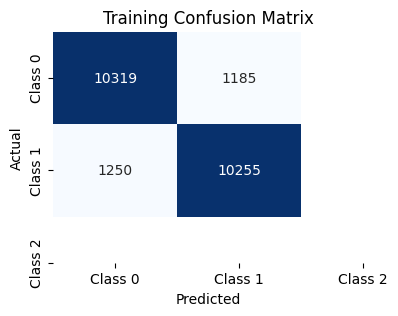

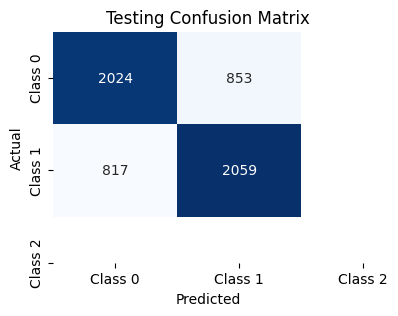


Classification Report for Training Data:
               precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     11504
         1.0       0.90      0.89      0.89     11505

    accuracy                           0.89     23009
   macro avg       0.89      0.89      0.89     23009
weighted avg       0.89      0.89      0.89     23009


Classification Report for Testing Data:
               precision    recall  f1-score   support

         0.0       0.71      0.70      0.71      2877
         1.0       0.71      0.72      0.71      2876

    accuracy                           0.71      5753
   macro avg       0.71      0.71      0.71      5753
weighted avg       0.71      0.71      0.71      5753



In [89]:
# Define the model with the best hyperparameters
model = lgb.LGBMClassifier(
    num_leaves=126,
    learning_rate=0.2751701213598749,
    max_depth=35,
    min_data_in_leaf=10,
    lambda_l1=7.511988202098125,
    lambda_l2=7.412844949836307,
    bagging_fraction=0.5954374457991968,
    feature_fraction=0.8296990927940129,
    n_estimators=100  # Adjust based on your needs
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on testing data
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Generate confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1', 'Class 2'],
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_train, title='Training Confusion Matrix')
plot_confusion_matrix(cm_test, title='Testing Confusion Matrix')

# Generate classification report for training and testing data
print("\nClassification Report for Training Data:\n", classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.8548394106653918
Testing Accuracy: 0.7011993742395272


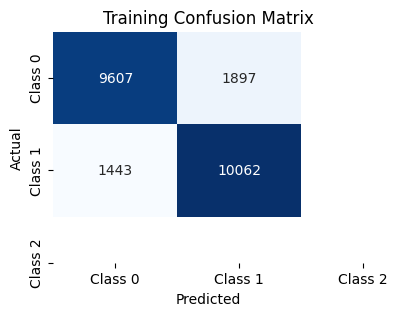

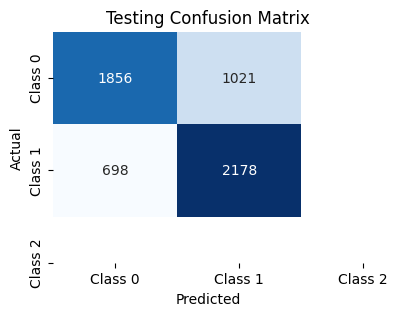


Classification Report for Training Data:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.85     11504
         1.0       0.84      0.87      0.86     11505

    accuracy                           0.85     23009
   macro avg       0.86      0.85      0.85     23009
weighted avg       0.86      0.85      0.85     23009


Classification Report for Testing Data:
               precision    recall  f1-score   support

         0.0       0.73      0.65      0.68      2877
         1.0       0.68      0.76      0.72      2876

    accuracy                           0.70      5753
   macro avg       0.70      0.70      0.70      5753
weighted avg       0.70      0.70      0.70      5753



In [88]:
# Define the model with the specified hyperparameters
model = lgb.LGBMClassifier(
    learning_rate=0.1,
    max_depth=-1,
    n_estimators=20,
    num_leaves=31
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on testing data
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Generate confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1', 'Class 2'],
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_train, title='Training Confusion Matrix')
plot_confusion_matrix(cm_test, title='Testing Confusion Matrix')

# Generate classification report for training and testing data
print("\nClassification Report for Training Data:\n", classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:\n", classification_report(y_test, y_test_pred))

In [ ]:
import pandas as pd

class Preprocessing:
    def __init__(self, df):
        self.df = df
        self.target_mean_feature=[]

    def handle_nulls(self):
        """Fill null values in specific columns."""
        self.df["enrolled_university"] = self.df["enrolled_university"].fillna("none")
        self.df["education_level"] = self.df["education_level"].fillna("Other")
        mode = self.df["experience"].mode()
        self.df["experience"] = self.df["experience"].fillna(mode[0])
        self.df["last_new_job"] = self.df["last_new_job"].fillna("Not Specified")
        self.df['major_discipline'] = self.df['major_discipline'].fillna("Not Specified")
        self.df["gender"] = self.df["gender"].fillna("Not Specified")
        self.df["company_size"] = self.df["company_size"].fillna("Not Specified")
        self.df["company_type"] = self.df["company_type"].fillna("Not Specified")

    def encode_features(self):
        """Encode categorical features with target mean."""
        features = ['gender', "enrolled_university", "major_discipline",
                    "education_level", "company_type", "city"]

        for i,feature in enumerate(features):
            self.target_mean_feature.append(self.df.groupby(feature)['target'].mean())
            self.df[feature] = self.df[feature].map(target_mean_feature[i])

        """Map relevant experience to binary values."""
        self.df["relevent_experience"] = self.df["relevent_experience"].map({
            'Has relevent experience': 1,
            'No relevent experience': 0
        })

        """Map company size categories to numerical values."""
        size_mapping = {
            'Not Specified': 1,
            '<10': 2,
            '10/49': 3,
            '50-99': 4,
            '100-500': 5,
            '500-999': 6,
            '1000-4999': 7,
            '5000-9999': 8,
            '10000+': 9
        }

        self.df["company_size"] = self.df["company_size"].replace(size_mapping)

        """Map last new job categories to numerical values."""
        last_new_job_mapping = {
            'Not Specified': 0,
            '<1': 1,
            '1': 2,
            '2': 3,
            '3': 4,
            '4': 5,
            '5': 6,
            '6': 7,
            '7': 8,
            '8': 9,
            '9': 10,
            '10': 11,
            '11': 12,
            '12': 13,
            '13': 14,
            '14': 15,
            '15': 16,
            '16': 17,
            '17': 18,
            '18': 19,
            '19': 20,
            '>20': 21
        }

        unique_jobs = sorted(self.df["last_new_job"].unique().tolist())

        # Map last new job based on unique values
        for i in unique_jobs:
            if i in last_new_job_mapping:
                self.df["last_new_job"] = self.df["last_new_job"].replace(i, last_new_job_mapping[i])

        """Map experience categories to numerical values."""
        experience_mapping = {
            '>20': 21,
            '<1': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            '6': 6,
            '7': 7,
            '8': 8,
            '9': 9,
            '10': 10,
            '11': 11,
            '12': 12,
            '13': 13,
            '14': 14,
            '15': 15,
            '16': 16,
            '17': 17,
            '18': 18,
            '19': 19,
            '20': 20
        }

        self.df["experience"] = self.df["experience"].map(experience_mapping)

    def preprocess(self):
        """Run all preprocessing steps."""
        self.handle_nulls()
        self.encode_features()


# Example usage:
# df = pd.read_csv('your_data.csv')
# preprocessor = Preprocessing(df)
# preprocessor.preprocess()
# processed_df = preprocessor.df